In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
import json
import os
import seaborn as sns

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class NetA(nn.Module):
    def __init__(self, kernel_size, stride):
        super(NetA, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self._initialize_weights()

    def _initialize_weights(self):
        with torch.no_grad():
            temp_tensor = torch.zeros(1, 3, 32, 32)
            temp_tensor = self.layer1(temp_tensor)
            self.flatten_size = temp_tensor.numel()

        self.fc = nn.Linear(self.flatten_size, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class NetB(nn.Module):
    def __init__(self, kernel_size, stride):
        super(NetB, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self._initialize_weights()

    def _initialize_weights(self):
        with torch.no_grad():
            temp_tensor = torch.zeros(1, 3, 32, 32)
            temp_tensor = self.layer1(temp_tensor)
            self.flatten_size = temp_tensor.numel()

        self.fc = nn.Linear(self.flatten_size, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
def train_and_evaluate(net, learning_rate, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"End {epoch+1} epoch!")
    
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [6]:
learning_rates = [0.001, 0.01, 0.1]
kernel_sizes = [3, 5, 7]
strides = [1, 2]
block_types = ['A', 'B']

results = []

# Проверка наличия файла результатов
if os.path.exists('results.json'):
    with open('results.json', 'r') as f:
        results = json.load(f)

# Генерация комбинаций гиперпараметров
combinations = list(itertools.product(learning_rates, kernel_sizes, strides, block_types))

# Пропуск уже обработанных комбинаций
processed_combinations = [(lr, ks, s, bt) for lr, ks, s, bt, _ in results]
remaining_combinations = [comb for comb in combinations if comb not in processed_combinations]

for lr, ks, s, bt in remaining_combinations:
    if bt == 'A':
        net = NetA(kernel_size=ks, stride=s)
    else:
        net = NetB(kernel_size=ks, stride=s)
    
    accuracy = train_and_evaluate(net, learning_rate=lr)
    results.append((lr, ks, s, bt, accuracy))
    print(f'Learning rate: {lr}, Kernel size: {ks}, Stride: {s}, Block type: {bt}, Accuracy: {accuracy}%')

    # Сохранение модели
    torch.save(net.state_dict(), f'saved/net_{bt}_lr{lr}_ks{ks}_s{s}.pth')

    # Сохранение промежуточных результатов
    with open('results.json', 'w') as f:
        json.dump(results, f)

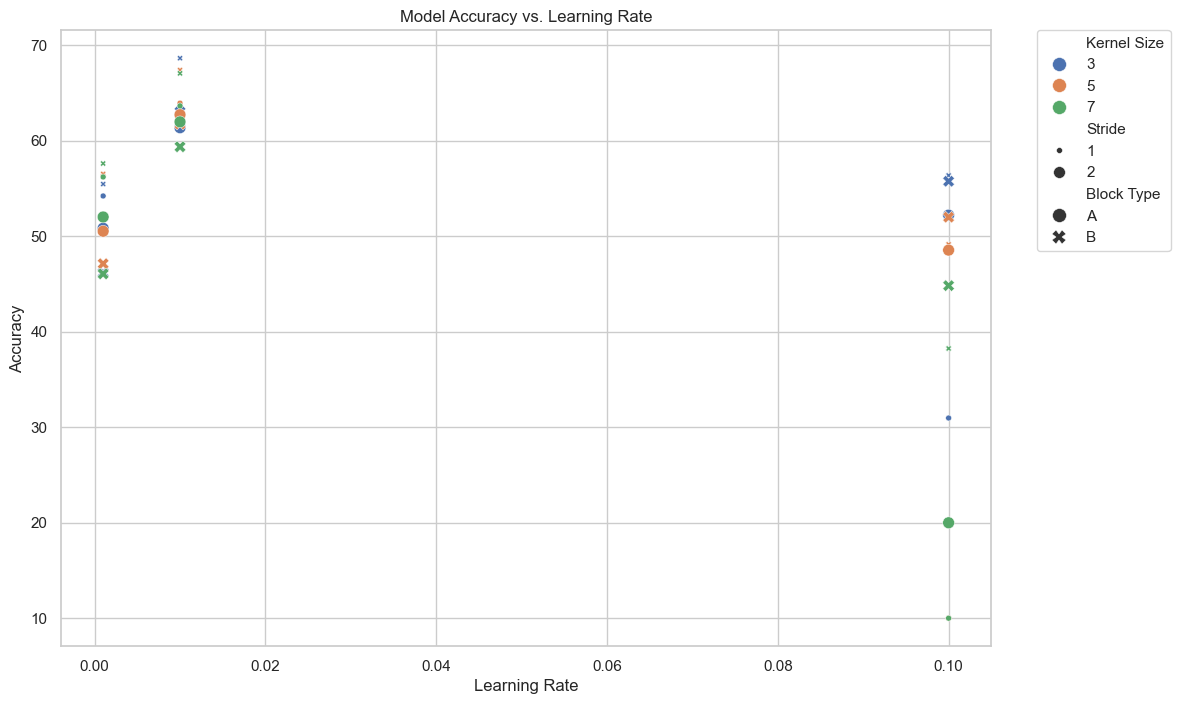

In [7]:
# Установка стиля seaborn
sns.set(style="whitegrid")

# Построение диаграмм
fig, ax = plt.subplots(figsize=(12, 8))

# Создание DataFrame для удобного построения графиков
import pandas as pd

df = pd.DataFrame(results, columns=['Learning Rate', 'Kernel Size', 'Stride', 'Block Type', 'Accuracy'])

# Построение графика с использованием seaborn
sns.scatterplot(
    data=df,
    x='Learning Rate',
    y='Accuracy',
    hue='Kernel Size',
    style='Block Type',
    size='Stride',
    palette='deep',
    s=100, # размер меток
    ax=ax
)

# Настройка осей и заголовка
ax.set_title('Model Accuracy vs. Learning Rate')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')

# Показ легенды и графика
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [8]:
# # Best model
# ks = 3
# s = 1
# lr = 0.01
# bt="B"
# net = NetB(kernel_size=ks, stride=s)
# accuracy = train_and_evaluate(net, learning_rate=lr, num_epochs=10)
# print(f'Learning rate: {lr}, Kernel size: {ks}, Stride: {s}, Block type: {bt}, Accuracy: {accuracy}%')

# # Сохранение модели
# torch.save(net.state_dict(), f'net_{bt}_lr{lr}_ks{ks}_s{s}.pth')

In [9]:
def load_model(file_name, kernel_size, stride, block_type):
    if block_type == 'A':
        model = NetA(kernel_size=kernel_size, stride=stride)
    else:
        model = NetB(kernel_size=kernel_size, stride=stride)
    
    model.load_state_dict(torch.load(file_name))
    return model

def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

kernel_size = 3
learning_rate = 0.01
stride = 1
block_type = 'B'
file_name = f'saved/net_{block_type}_lr{learning_rate}_ks{kernel_size}_s{stride}.pth'

model = load_model(file_name, kernel_size, stride, block_type)
accuracy = test_model(model)
print(f'Accuracy of the loaded model: {accuracy}%')

Accuracy of the loaded model: 67.9%
